# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [ ]:
!nvidia-smi

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [ ]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import json
import optuna
import shutil
import pandas as pd

import torch
# from ultralytics import YOLO

from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

In [3]:
from lib.YOLO_lib.custom_layers import R_ELAN, C2PSA, A2
from ultralytics.nn import tasks
import torch

for k,v in {"R_ELAN":R_ELAN,"C2PSA":C2PSA,"A2":A2,"Upsample":torch.nn.Upsample}.items():
    setattr(tasks,k,v)

selected_model = "custom_yolo12s"
yaml_path = f"yolo/yolo_models/{selected_model}.yaml"
print("Registrado Upsample:", hasattr(tasks,"Upsample"))

from ultralytics import YOLO
model = YOLO(yaml_path)
print("Modelo OK")

Registrado Upsample: True


RuntimeError: Given groups=1, weight of size [512, 512, 1, 1], expected input[1, 256, 8, 8] to have 512 channels, but got 256 channels instead

In [ ]:
selected_model = "yolov12sy" 
model_dir = "yolo/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")
# model_path = os.path.join(model_dir, f"{selected_model}.yaml")

if selected_model not in config.models:
    model = YOLO(f"{selected_model}.pt")
    # model = YOLO(f"{selected_model}.yaml")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        shutil.move(f"{selected_model}.pt", model_path)
        # shutil.move(f"{selected_model}.yaml", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [4]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"
name_best_params = f"best_params_{selected_model}"

### **Optuna**

In [ ]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED),  
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10)
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

In [ ]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [ ]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 350 imagenes en 5 folds.

In [ ]:
metrics_df = kfold_utils.train(model, best_params, model_output_kfold)

In [ ]:
kfold_utils.save_results(metrics_df, model_output_kfold)

In [ ]:
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [5]:
params = getattr(config, name_best_params)

model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,         
    **params
)

New https://pypi.org/project/ultralytics/8.3.176 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005399484409787433, lrf=0.003991305878561679, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolov10s.pt, momentum=0.9062108866694067, mosaic=0, multi_scale

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 688.3103.0 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_yolov10s\labels.jpg... 
optimizer: SGD(lr=0.005399484409787433, momentum=0.9062108866694067) with parameter groups 99 weight(decay=0.0), 112 weight(decay=9.830050992369968e-05), 111 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov10s
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.73G      4.952      15.89      2.618        139        704: 100%|██████████| 28/28 [00:28<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        846      0.471       0.45      0.441      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.79G      3.257      3.163      2.022        130        704: 100%|██████████| 28/28 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all         70        846      0.567      0.577      0.531      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.77G      3.038      2.675      1.939        186        704: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all         70        846      0.714      0.765      0.813      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.89G      2.906      3.272      1.883        140        704: 100%|██████████| 28/28 [00:29<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all         70        846      0.665      0.678      0.707      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.83G      2.628      2.913      1.823        187        704: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

                   all         70        846        0.2      0.284      0.121     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.75G      2.734      2.898      1.852         88        704: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all         70        846      0.579      0.651      0.593      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.88G      2.595       2.27      1.815        137        704: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all         70        846      0.663       0.74      0.756      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.81G      2.735      1.996      1.839        124        704: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


                   all         70        846      0.731      0.743      0.798      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.76G       2.69      1.943       1.83         71        704: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all         70        846      0.746       0.76      0.805      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.87G       2.44      1.862      1.782         67        704: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

                   all         70        846      0.789      0.724      0.834      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.76G      2.319      1.826      1.777         77        704: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         70        846      0.765      0.774      0.846      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.83G      2.233      1.784      1.755        104        704: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all         70        846      0.755      0.786      0.846      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.8G      2.468      1.689      1.776        102        704: 100%|██████████| 28/28 [00:14<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all         70        846      0.796      0.807       0.87      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       3.8G      2.154      1.551      1.728        149        704: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         70        846      0.846      0.751      0.874      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.81G      2.145      1.505      1.733        161        704: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all         70        846      0.809      0.824      0.883       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.76G      2.127      1.448       1.74        132        704: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all         70        846      0.814      0.839      0.887      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.81G      2.074      1.388      1.725        201        704: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         70        846      0.815      0.852      0.889      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.83G      2.055      1.385      1.719        155        704: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all         70        846      0.839      0.817      0.896      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.79G      1.979      1.345      1.703        203        704: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all         70        846      0.811       0.85      0.893       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.78G      1.985      1.312      1.704         85        704: 100%|██████████| 28/28 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all         70        846      0.814      0.866      0.903      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.81G       1.86      1.281      1.682        171        704: 100%|██████████| 28/28 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all         70        846      0.789      0.887      0.893       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.81G      1.922      1.281      1.697        156        704: 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all         70        846      0.841       0.85      0.903      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       3.8G      1.964      1.298      1.694         52        704: 100%|██████████| 28/28 [00:24<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

                   all         70        846      0.855      0.822      0.897      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.77G      1.795      1.311      1.685        167        704: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all         70        846      0.792      0.876      0.891       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.78G      1.872      1.275      1.683        250        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all         70        846      0.818      0.856      0.896      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       3.8G      1.896      1.246      1.694         79        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all         70        846      0.838      0.832        0.9      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.79G      1.797      1.272      1.678        233        704: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all         70        846      0.819      0.882      0.908      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.81G      1.792      1.223      1.679        126        704: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all         70        846      0.806      0.881      0.904      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.89G      1.724      1.216      1.664        144        704: 100%|██████████| 28/28 [00:32<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         70        846      0.815      0.872      0.901      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       3.8G      1.726       1.18      1.666        193        704: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all         70        846      0.842      0.853      0.904      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.83G      1.646      1.174      1.652        116        704: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all         70        846      0.828      0.876      0.907      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.86G       1.71       1.18       1.67        133        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all         70        846      0.838      0.854      0.908      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.83G      1.729      1.178      1.655        155        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all         70        846      0.851      0.858      0.908       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.84G      1.641      1.168      1.646        155        704: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all         70        846      0.826      0.863      0.904       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       3.9G      1.618      1.173      1.653        131        704: 100%|██████████| 28/28 [00:24<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

                   all         70        846      0.826      0.865      0.903      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.77G      1.641      1.153      1.654         81        704: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]

                   all         70        846      0.837      0.864      0.903      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.85G      1.611      1.114      1.641         97        704: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         70        846      0.857      0.844      0.905      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.75G      1.592      1.158      1.644        128        704: 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all         70        846      0.836      0.861      0.907      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.86G      1.578      1.112      1.646         89        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all         70        846      0.834      0.863      0.909      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.84G      1.607      1.119      1.644        105        704: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all         70        846      0.834      0.874      0.909        0.7



40 epochs completed in 0.259 hours.
Optimizer stripped from runs\detect\final_model_yolov10s\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\final_model_yolov10s\weights\best.pt, 16.5MB

Validating runs\detect\final_model_yolov10s\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


                   all         70        846      0.834      0.864      0.909      0.701
Speed: 0.7ms preprocess, 7.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\final_model_yolov10s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002C806360690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

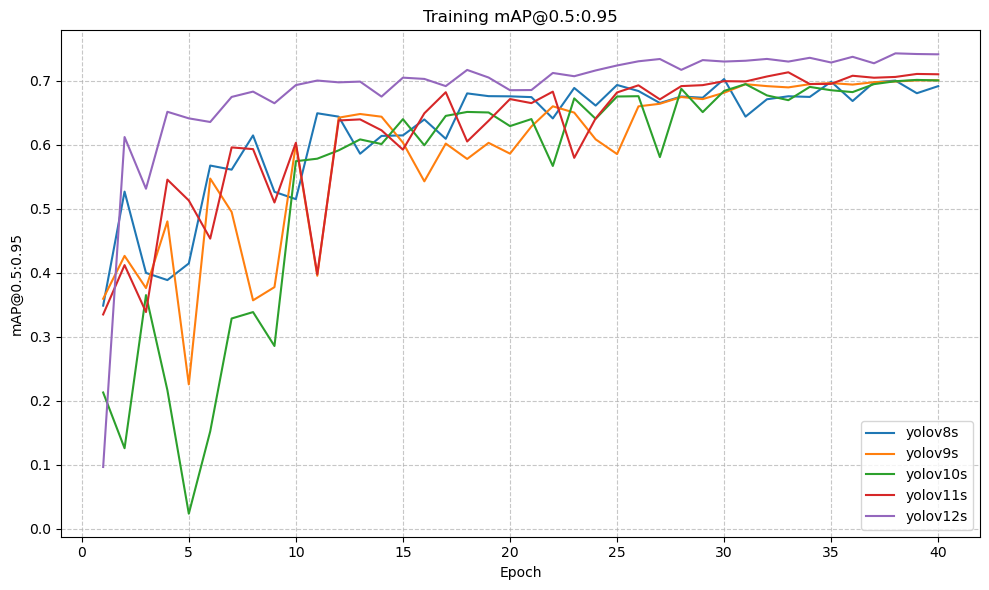

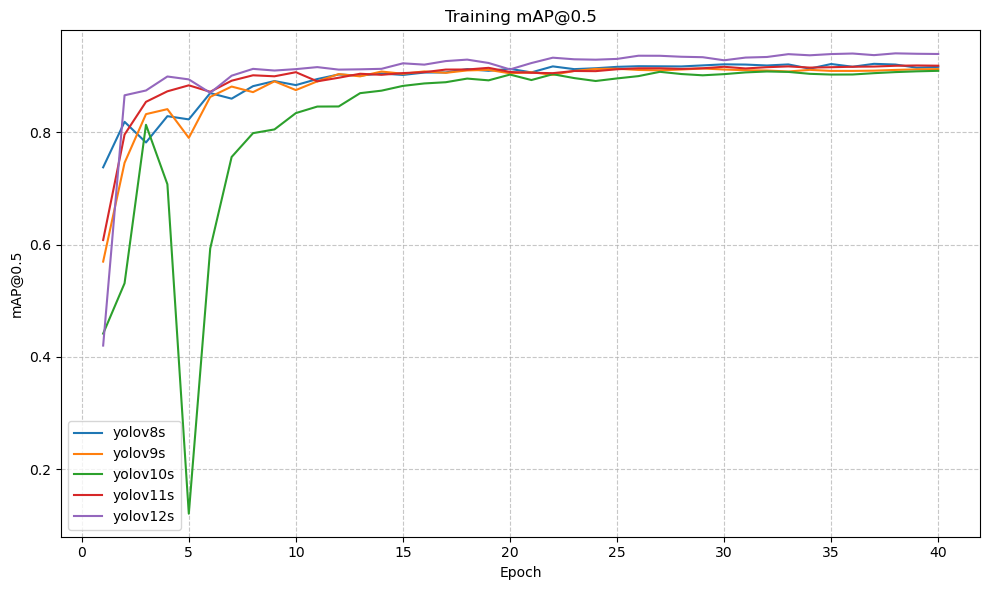

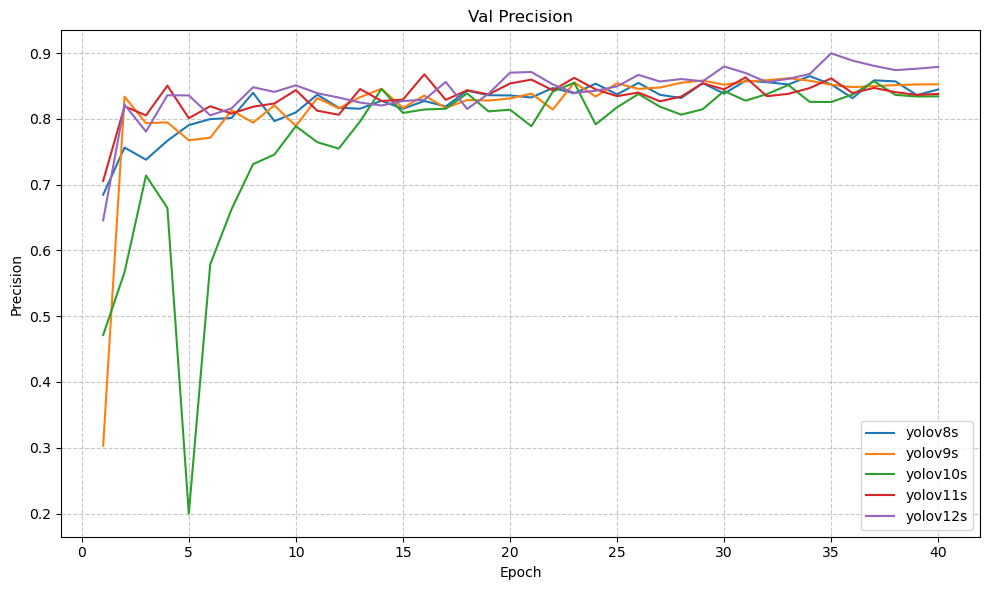

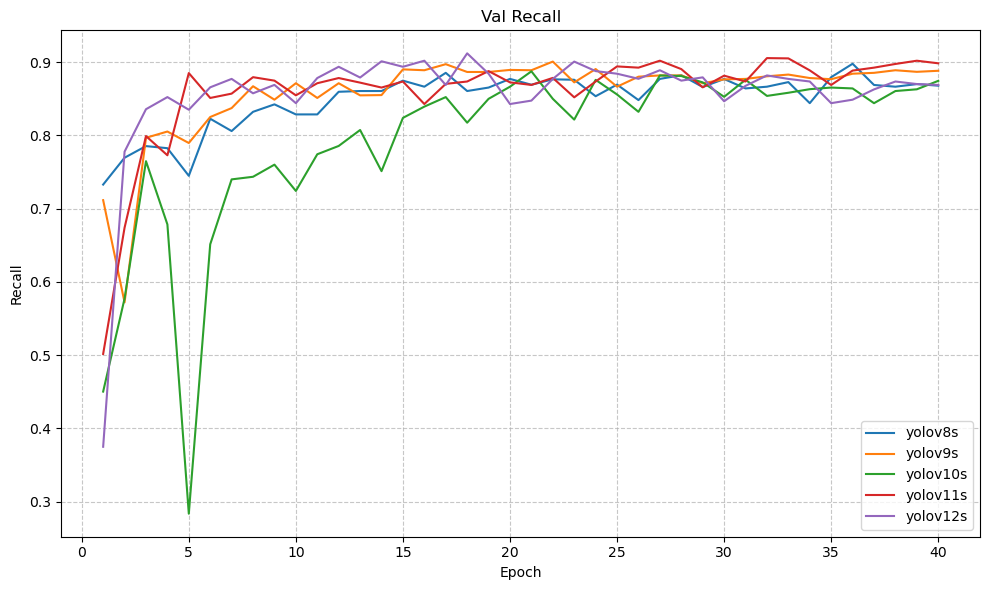

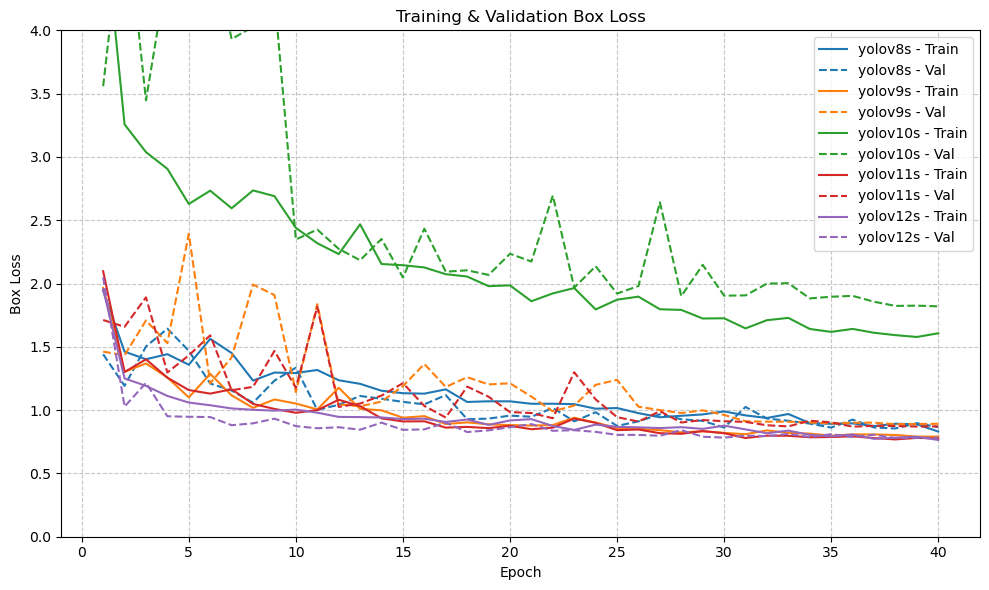

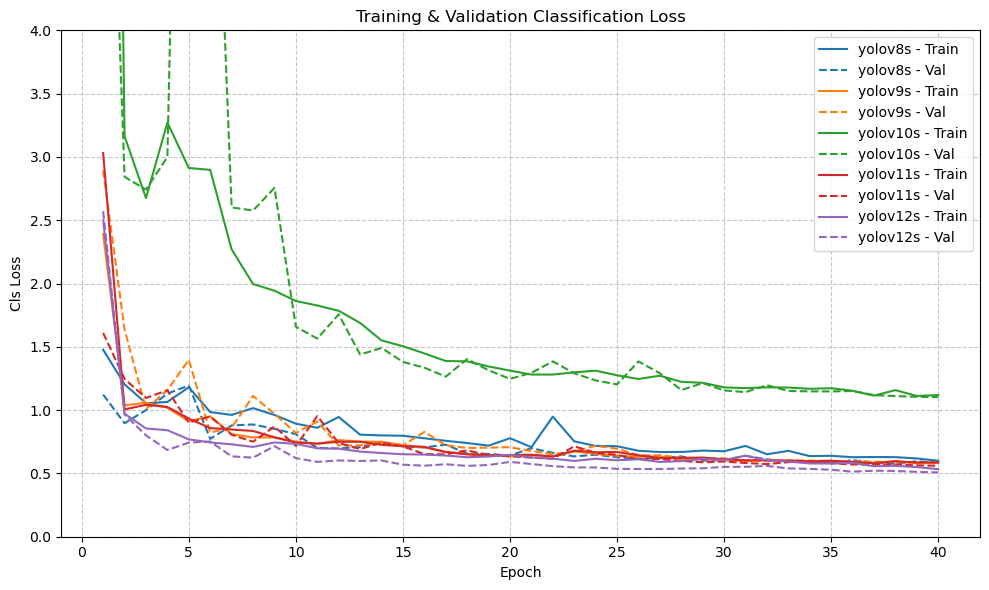

In [3]:
plots_dir = 'yolo/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluaciones de empresa**

In [4]:
tests = ["test", "test2", "test3"]
results = []
for test in tests:
    for name, path in config.final_model_path.items():
        model = YOLO(path)
        metrics = model.val(
            data="cells.yaml",
            split=test,
            imgsz=config.IMGSZ,
            batch=config.BATCH,
            name=f"eval_{name}_{test}"
        )
        results.append({
            "Modelo": name,
            "Test": test,
            "Precisión": metrics.box.mp,
            "Recall": metrics.box.mr,
            "mAP@0.5": metrics.box.map50,
            "mAP@0.5:0.95": metrics.box.map
        })

Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 141.028.7 MB/s, size: 114.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.72it/s]


                   all         88       1412      0.857      0.839      0.926      0.705
Speed: 1.3ms preprocess, 11.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 838.7315.3 MB/s, size: 104.7 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


                   all         88       1412       0.85      0.878      0.934      0.707
Speed: 1.4ms preprocess, 13.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 941.9220.2 MB/s, size: 107.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


                   all         88       1412      0.854      0.862      0.928      0.701
Speed: 1.1ms preprocess, 11.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 815.3324.6 MB/s, size: 91.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


                   all         88       1412      0.847      0.867      0.932      0.717
Speed: 1.2ms preprocess, 10.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 943.3239.0 MB/s, size: 107.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


                   all         88       1412      0.863      0.849      0.937      0.741
Speed: 1.3ms preprocess, 14.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 166.517.3 MB/s, size: 109.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


                   all         10        144      0.924      0.938      0.969      0.553
Speed: 0.4ms preprocess, 12.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test2
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 906.3149.2 MB/s, size: 103.9 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


                   all         10        144      0.917      0.927      0.961      0.542
Speed: 0.4ms preprocess, 17.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test2
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 985.7181.0 MB/s, size: 104.1 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


                   all         10        144      0.956      0.898      0.962      0.589
Speed: 0.4ms preprocess, 13.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test2
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 971.2175.9 MB/s, size: 106.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


                   all         10        144      0.929      0.917      0.964      0.534
Speed: 0.4ms preprocess, 12.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test2
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 961.098.5 MB/s, size: 102.1 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


                   all         10        144      0.965      0.917      0.975      0.556
Speed: 0.4ms preprocess, 19.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test2
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.30.0 ms, read: 279.228.7 MB/s, size: 265.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


                   all         59       1135      0.842      0.862      0.937        0.7
Speed: 0.8ms preprocess, 12.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1871.4246.6 MB/s, size: 264.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


                   all         59       1135      0.843       0.87      0.935      0.681
Speed: 1.5ms preprocess, 15.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1978.4314.7 MB/s, size: 277.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


                   all         59       1135      0.873      0.826      0.926      0.668
Speed: 2.1ms preprocess, 12.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1629.1227.2 MB/s, size: 273.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


                   all         59       1135      0.855      0.874      0.935      0.698
Speed: 2.4ms preprocess, 11.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test3
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1194.0193.4 MB/s, size: 261.6 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


                   all         59       1135      0.836      0.821      0.922      0.723
Speed: 2.8ms preprocess, 15.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test3


In [5]:
df = pd.DataFrame(results)
display(df)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95
0,yolov8s,test,0.856835,0.839247,0.926338,0.705017
1,yolov9s,test,0.849800,0.878187,0.933841,0.706728
2,yolov10s,test,0.853619,0.861898,0.927687,0.701377
3,yolov11s,test,0.847019,0.866592,0.931684,0.716655
4,yolov12s,test,0.863138,0.848629,0.937264,0.740666
5,yolov8s,test2,0.923798,0.937500,0.968788,0.553424
6,yolov9s,test2,0.917499,0.926773,0.961256,0.541765
7,yolov10s,test2,0.955656,0.897971,0.962268,0.588724
8,yolov11s,test2,0.928950,0.916667,0.964048,0.534350
9,yolov12s,test2,0.964634,0.916667,0.974530,0.555905


## ENSEMBLE

In [8]:
# === Ensemble: Concat+NMS y Weighted Boxes Fusion (WBF) y evaluación en test, test2, test3 ===
# Requiere: pip install ensemble-boxes (solo para WBF)
# %pip install ensemble-boxes

import os, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO

try:
    from ensemble_boxes import weighted_boxes_fusion
    HAS_WBF = True
except ImportError:
    HAS_WBF = False
    print("Instala ensemble-boxes para WBF: pip install ensemble-boxes")

# Modelos base seleccionados para el ensemble
ensemble_model_paths = {
    "yolov12s": config.final_model_path["yolov12s"],
    "yolov11s": config.final_model_path["yolov11s"],
    "yolov10s":  config.final_model_path["yolov8s"],
}

base_models = {k: YOLO(p) for k,p in ensemble_model_paths.items()}

# Pesos (puedes ajustarlos usando mAP@0.5:0.95 de validación)
model_weights = {
    "yolov12s": 0.8,
    "yolov11s": 0.4,
    "yolov10s":  0.75
}

# Utilidades
def load_yolo_labels(label_file):
    boxes = []
    if not os.path.exists(label_file):
        return np.zeros((0,5), dtype=float)
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=float) if boxes else np.zeros((0,5), dtype=float)

def yolo_to_xyxy_norm(boxes):
    # boxes: (N,5) cls, cx, cy, w, h (normalizado)
    if boxes.size == 0:
        return boxes[:, :0]
    cx, cy, w, h = boxes[:,1], boxes[:,2], boxes[:,3], boxes[:,4]
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return np.stack([x1,y1,x2,y2], axis=1)

def xyxy_to_yolo_norm(xyxy):
    # xyxy normalizado -> (cx,cy,w,h)
    if xyxy.size == 0:
        return xyxy[:, :0]
    x1,y1,x2,y2 = xyxy[:,0], xyxy[:,1], xyxy[:,2], xyxy[:,3]
    w = x2 - x1
    h = y2 - y1
    cx = x1 + w/2
    cy = y1 + h/2
    return np.stack([cx,cy,w,h], axis=1)

def iou_matrix(a, b):
    # a,b: (N,4) (M,4) en formato xyxy normalizado
    if a.size == 0 or b.size == 0:
        return np.zeros((len(a), len(b)), dtype=float)
    ious = np.zeros((len(a), len(b)), dtype=float)
    for i, box_a in enumerate(a):
        ax1, ay1, ax2, ay2 = box_a
        aarea = max(0, ax2-ax1) * max(0, ay2-ay1)
        for j, box_b in enumerate(b):
            bx1, by1, bx2, by2 = box_b
            barea = max(0, bx2-bx1) * max(0, by2-by1)
            ix1 = max(ax1, bx1)
            iy1 = max(ay1, by1)
            ix2 = min(ax2, bx2)
            iy2 = min(ay2, by2)
            iw = max(0, ix2-ix1)
            ih = max(0, iy2-iy1)
            inter = iw * ih
            union = aarea + barea - inter
            ious[i,j] = inter / union if union > 0 else 0.0
    return ious

def soft_nms(boxes, scores, iou_thr=0.9, sigma=0.9, score_thr=0.9):
    # boxes: (N,4), scores: (N,)
    boxes = boxes.copy()
    scores = scores.copy()
    N = boxes.shape[0]
    keep = []
    for i in range(N):
        maxscore = scores[i]
        maxpos = i

        # Get max score box
        for j in range(i+1, N):
            if scores[j] > maxscore:
                maxscore = scores[j]
                maxpos = j
        # Swap
        boxes[i], boxes[maxpos] = boxes[maxpos].copy(), boxes[i].copy()
        scores[i], scores[maxpos] = scores[maxpos], scores[i]

        boxA = boxes[i]
        for j in range(i+1, N):
            boxB = boxes[j]
            # IoU
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0.0, xx2 - xx1)
            h = max(0.0, yy2 - yy1)
            inter = w * h
            areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
            areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
            iou = inter / (areaA + areaB - inter) if (areaA + areaB - inter) > 0 else 0.0

            # Soft-NMS
            if iou > iou_thr:
                scores[j] *= np.exp(- (iou ** 2) / sigma)
        if scores[i] > score_thr:
            keep.append(i)
    return np.array(keep)

def nms_concat(pred_lists, iou_thr=0.9, conf_thr=0.9, use_soft_nms=True):
    # pred_lists: lista de dicts con keys: boxes (xyxy norm), conf, cls
    if not pred_lists:
        return np.zeros((0,6))
    all_boxes = []
    for p in pred_lists:
        boxes = p["boxes"]
        scores = p["conf"]
        cls = p["cls"]
        arr = np.concatenate([boxes, scores[:,None], cls[:,None]], axis=1)
        all_boxes.append(arr)
    dets = np.concatenate(all_boxes, axis=0)
    dets = dets[dets[:,4] >= conf_thr]
    if dets.shape[0] == 0:
        return dets
    keep_final = []
    for c in np.unique(dets[:,5]):
        dc = dets[dets[:,5]==c]
        if use_soft_nms:
            idx = soft_nms(dc[:,:4], dc[:,4], iou_thr=iou_thr, sigma=0.5, score_thr=conf_thr)
        else:
            tboxes = torch.tensor(dc[:,:4])
            tscores = torch.tensor(dc[:,4])
            idx = torch.ops.torchvision.nms(tboxes, tscores, iou_thr).numpy()
        keep_final.append(dc[idx])
    return np.concatenate(keep_final, axis=0) if keep_final else np.zeros((0,6))

def predict_single_model(model, image_path, imgsz):
    r = model.predict(image_path, imgsz=imgsz, conf=0.001, verbose=False)[0]
    h, w = r.orig_shape
    if r.boxes.shape[0] == 0:
        return {"boxes": np.zeros((0,4)), "conf": np.zeros((0,)), "cls": np.zeros((0,))}
    xyxy = r.boxes.xyxy.cpu().numpy()
    conf = r.boxes.conf.cpu().numpy()
    cls = r.boxes.cls.cpu().numpy()
    # Normalizar
    xyxy_norm = xyxy.copy()
    xyxy_norm[:,[0,2]] /= w
    xyxy_norm[:,[1,3]] /= h
    return {"boxes": xyxy_norm, "conf": conf, "cls": cls}

def ensemble_concat_nms(image_path, imgsz=704, iou_thr=0.90, conf_thr=0.9):
    plist = [predict_single_model(m, image_path, imgsz) for m in base_models.values()]
    dets = nms_concat(plist, iou_thr=iou_thr, conf_thr=conf_thr)
    return dets  # (N,6) xyxy + conf + cls (normalizado)

def ensemble_wbf(image_path, imgsz=704, iou_thr=0.9, skip_box_thr=0.5):
    if not HAS_WBF:
        return np.zeros((0,6))
    boxes_list, scores_list, labels_list, weights = [], [], [], []
    shapes = None
    for name, m in base_models.items():
        r = predict_single_model(m, image_path, imgsz)
        boxes_list.append(r["boxes"].tolist())
        scores_list.append(r["conf"].tolist())
        labels_list.append(r["cls"].astype(int).tolist())
        weights.append(model_weights[name])
    if sum(len(b) for b in boxes_list) == 0:
        return np.zeros((0,6))
    fused_boxes, fused_scores, fused_labels = weighted_boxes_fusion(
        boxes_list, scores_list, labels_list,
        weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr
    )
    fused_boxes = np.array(fused_boxes)
    fused_scores = np.array(fused_scores)
    fused_labels = np.array(fused_labels)
    return np.concatenate([fused_boxes, fused_scores[:,None], fused_labels[:,None]], axis=1)

# Métricas (AP@0.5 y AP@[0.5:0.95], precisión y recall global)
def compute_metrics(preds_all, gts_all, iou_thresholds=None):
    # preds_all & gts_all: listas por imagen
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
    # Para precisión/recall global a IoU=0.5 (primera)
    iou_main = iou_thresholds[0]
    tp_main = 0
    fp_main = 0
    fn_main = 0

    # AP por IoU
    APs = []
    for t in iou_thresholds:
        scores = []
        matches = []
        total_gts = 0
        # Recolectar predicciones (1 clase)
        all_pred_entries = []
        for preds, gts in zip(preds_all, gts_all):
            # gts: (M,4) xyxy norm
            total_gts += gts.shape[0]
            if preds.shape[0] == 0:
                continue
            # Ordenar por score
            order = np.argsort(-preds[:,4])
            p = preds[order]
            matched = np.zeros(gts.shape[0], dtype=bool)
            for row in p:
                box_p = row[:4][None,:]
                ious = iou_matrix(box_p, gts)
                best_i = np.argmax(ious[0]) if gts.shape[0] else -1
                best_iou = ious[0,best_i] if gts.shape[0] else 0
                is_tp = best_iou >= t and (best_i >=0) and (not matched[best_i])
                if is_tp:
                    matched[best_i] = True
                all_pred_entries.append((row[4], 1 if is_tp else 0))
            # fin imagen
        if total_gts == 0:
            APs.append(0.0)
            continue
        if not all_pred_entries:
            APs.append(0.0)
            continue
        all_pred_entries.sort(key=lambda x: -x[0])
        cum_tp = 0
        cum_fp = 0
        precisions = []
        recalls = []
        for sc, is_tp in all_pred_entries:
            if is_tp:
                cum_tp += 1
            else:
                cum_fp += 1
            precisions.append(cum_tp / (cum_tp + cum_fp))
            recalls.append(cum_tp / total_gts)
        # AP (interp 11 pts estilo voc o integración)
        # Usamos integración trapezoidal sobre recall ordenado
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        # Asegurar monotonicidad descendente
        for i in range(len(precisions)-2, -1, -1):
            precisions[i] = max(precisions[i], precisions[i+1])
        # Puntos únicos en recall
        unique_recalls, idx = np.unique(recalls, return_index=True)
        ap = np.trapz(precisions[idx], unique_recalls)
        APs.append(ap)

        if math.isclose(t, iou_main):
            # Compute global precision/recall at main IoU (usar mismos matches)
            # Repetimos conteo
            total_gts_main = 0
            tp_m = 0
            fp_m = 0
            for preds, gts in zip(preds_all, gts_all):
                total_gts_main += gts.shape[0]
                if preds.shape[0] == 0:
                    continue
                order = np.argsort(-preds[:,4])
                p = preds[order]
                matched = np.zeros(gts.shape[0], dtype=bool)
                for row in p:
                    box_p = row[:4][None,:]
                    ious = iou_matrix(box_p, gts)
                    best_i = np.argmax(ious[0]) if gts.shape[0] else -1
                    best_iou = ious[0,best_i] if gts.shape[0] else 0
                    if best_iou >= iou_main and best_i >=0 and (not matched[best_i]):
                        matched[best_i] = True
                        tp_m += 1
                    else:
                        fp_m += 1
            fn_m = total_gts_main - tp_m
            tp_main, fp_main, fn_main = tp_m, fp_m, fn_m

    mp = tp_main / (tp_main + fp_main) if (tp_main + fp_main) > 0 else 0.0
    mr = tp_main / (tp_main + fn_main) if (tp_main + fn_main) > 0 else 0.0
    map50 = APs[0] if len(APs) > 0 else 0.0
    map5095 = float(np.mean(APs)) if APs else 0.0
    return {
        "mp": mp,
        "mr": mr,
        "map50": map50,
        "map": map5095
    }

def get_split_image_label_dirs(split_name):
    base = Path("..") / "03.Datasets" / "YOLO_Datasets"
    images = base / split_name / "images"
    labels = base / split_name / "labels"
    return images, labels

def evaluate_ensemble(split, method="concat_nms", imgsz=config.IMGSZ):
    img_dir, label_dir = get_split_image_label_dirs(split)
    image_paths = [p for p in img_dir.iterdir() if p.suffix.lower() in [".jpg", ".png", ".jpeg"]]
    preds_all = []
    gts_all = []
    for img_path in image_paths:
        # Ground truth
        gt_label = (label_dir / (img_path.stem + ".txt"))
        gts_raw = load_yolo_labels(str(gt_label))  # cls, cx, cy, w, h
        gts_xyxy = yolo_to_xyxy_norm(gts_raw) if gts_raw.size else np.zeros((0,4))
        gts_all.append(gts_xyxy)

        if method == "concat_nms":
            dets = ensemble_concat_nms(str(img_path), imgsz=imgsz, iou_thr=0.60, conf_thr=0.2)
        elif method == "wbf":
            dets = ensemble_wbf(str(img_path), imgsz=imgsz, iou_thr=0.50, skip_box_thr=0.3)
        else:
            dets = np.zeros((0,6))

        # dets: (N,6) xyxy + conf + cls
        preds_all.append(dets if dets.size else np.zeros((0,6)))
    metrics = compute_metrics(preds_all, gts_all)
    return metrics

test_splits = ["test","test2","test3"]
ensemble_results = []
for split in test_splits:
    # m1 = evaluate_ensemble(split, method="concat_nms")
    # ensemble_results.append({
    #     "Modelo": "ensemble_concat_nms",
    #     "Test": split,
    #     "Precisión": m1["mp"],
    #     "Recall": m1["mr"],
    #     "mAP@0.5": m1["map50"],
    #     "mAP@0.5:0.95": m1["map"]
    # })
    m2 = evaluate_ensemble(split, method="wbf")
    ensemble_results.append({
        "Modelo": "ensemble_wbf",
        "Test": split,
        "Precisión": m2["mp"],
        "Recall": m2["mr"],
        "mAP@0.5": m2["map50"],
        "mAP@0.5:0.95": m2["map"]
    })

df_ensemble = pd.DataFrame(ensemble_results)
display(df_ensemble)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95
0,ensemble_wbf,test,0.840589,0.888810,0.866627,0.687113
1,ensemble_wbf,test2,0.895425,0.951389,0.938807,0.490459
2,ensemble_wbf,test3,0.833198,0.906608,0.884262,0.702570


Quitar los map no sirven en esta comparativa pero usar la amtriz de confusión

| Imagen            | Test      | yolov8s 0.5 | yolov8s 0.7 | yolov9s 0.5 | yolov9s 0.7 | yolov10s 0.5 | yolov10s 0.7 | yolov11s 0.5 | yolov11s 0.7 | yolov12s 0.5 | yolov12s 0.7 |
|-------------------|:---------:|:-----------:|:-----------:|:-----------:|:-----------:|:------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| 59 imagen         |     1     |      ❌    |      ✅     |     ❌      |     ✅      |     ❌      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| 61 imagen         |     1     |      ❌    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| 219 imagen        |     1     |      ❌    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| 369 imagen        |     1     |      ✅    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| already tested-00 |     3     |      ✅    |      ✅     |     ✅      |     ✅      |     ✅      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| already tested-15 |     3     |      ✅    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| already tested-16 |     3     |      ✅    |      ✅     |     ❌      |     ✅      |     ✅      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| already tested-17 |     3     |      ✅    |      ✅     |     ✅      |     ✅      |     ✅      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| already tested-22 |     3     |      ✅    |      ✅     |     ✅      |     ✅      |     ❌      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file

comentar en la memoria el uso de linters como ruff